In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.nn as nn
from torchvision import models
import numpy as np
import cv2
from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
image_path = "/home/cropped_panda.jpg"

```python
 normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])


In [4]:
transform_compose= transforms.Compose([
    # im = im.resize((224,224))
    transforms.Resize((224,224)),
    transforms.ToTensor(),    # PIL -> tensor
    # 书上是先标准 再归一  我这先归一再标准没事吧，，，
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])   
])


im = Image.open(image_path).convert('RGB')

img = transform_compose(im)
# HWC -> CHW 好像自动转了 那就不用问了
# img.shape  #torch.Size([3, 224, 224])
# -> [1,3,224,224]  don't know why
# img = np.array(img).expand_dims(img)
# pytorch 中用 unsqueeze(0) 就可
img = img.unsqueeze(0)
# img.shape #torch.Size([1, 3, 224, 224])
img = Variable(img.to(device).float())

In [5]:
# 直接装模型 
model = models.alexnet(pretrained=True).to(device).eval()

label=np.argmax(model(img).data.cpu().numpy())
print("label={}".format(label)) 

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


label=388


In [6]:
img.requires_grad = True
for param in model.parameters():
  param.requires_grad = False
optimizer = torch.optim.Adam([img])

In [7]:
target = 288
target = Variable(torch.Tensor([float(target)]).to(device).long())
loss_func = torch.nn.CrossEntropyLoss()

In [8]:
target

tensor([288])

In [9]:
epochs = 100
for epoch in range(epochs):
  optimizer.zero_grad()
  output = model(img)
  # print(output)
  # print(target)
  loss = loss_func(output,target)
  label = np.argmax(output.data.cpu().numpy())
  print("epoch={}  loss={}  label={}".format(epoch,loss,label))
  if label == target:
    break
  loss.backward()
  optimizer.step()

epoch=0  loss=12.355485916137695  label=388
epoch=1  loss=11.30117130279541  label=388
epoch=2  loss=10.41605281829834  label=388
epoch=3  loss=9.69015884399414  label=388
epoch=4  loss=9.069540023803711  label=388
epoch=5  loss=8.55005168914795  label=388
epoch=6  loss=8.116604804992676  label=388
epoch=7  loss=7.736799240112305  label=388
epoch=8  loss=7.38704776763916  label=388
epoch=9  loss=7.05974817276001  label=388
epoch=10  loss=6.742016792297363  label=388
epoch=11  loss=6.433605194091797  label=388
epoch=12  loss=6.135789394378662  label=388
epoch=13  loss=5.850050926208496  label=388
epoch=14  loss=5.563406944274902  label=388
epoch=15  loss=5.290186882019043  label=388
epoch=16  loss=5.000340938568115  label=388
epoch=17  loss=4.715740203857422  label=388
epoch=18  loss=4.423948287963867  label=388
epoch=19  loss=4.132595539093018  label=388
epoch=20  loss=3.835428476333618  label=388
epoch=21  loss=3.543227195739746  label=388
epoch=22  loss=3.257934331893921  label=293
e

In [10]:
# 有点奇怪 他这不是在训练model？
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
def postprocess(img_tensor,rgb_mean,rgb_std):
    rgb_mean= np.array(rgb_mean)
    rgb_std= np.array(rgb_std)
    inv_normalize = torchvision.transforms.Normalize(
        mean= -rgb_mean / rgb_std,
        std= 1/rgb_std)
    #参考 https://blog.csdn.net/qq_42079689/article/details/102574358 倒推得到
    to_PIL_image = torchvision.transforms.ToPILImage()
    #这里不用再调整size了，因为后处理是处理生成的图片，只有一张
    return to_PIL_image(inv_normalize(img_tensor[0].cpu()).clamp(0, 1))

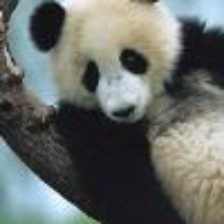

In [11]:
attacked = postprocess(img,mean,std)
attacked

In [12]:
np.array(mean) / np.array(std)

array([2.11790393, 2.03571429, 1.80444444])

In [13]:
#对比展现原始图片和对抗样本图片
def show_images_diff(original_img,original_label,adversarial_img,adversarial_label):
    import matplotlib.pyplot as plt
    plt.figure()

    #归一化
    if original_img.any() > 1.0:
        original_img=original_img/255.0
    if adversarial_img.any() > 1.0:
        adversarial_img=adversarial_img/255.0

    plt.subplot(131)
    plt.title('Original')
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(132)
    plt.title('Adversarial')
    plt.imshow(adversarial_img)
    plt.axis('off')

    plt.subplot(133)
    plt.title('Adversarial-Original')
    difference = adversarial_img - original_img
    #(-1,1)  -> (0,1)
    difference=difference / abs(difference).max()/2.0+0.5
    plt.imshow(difference,cmap=plt.cm.gray)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

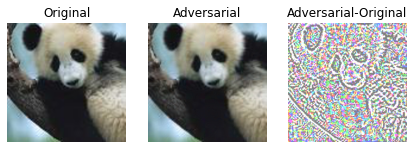

In [14]:
org = np.array(Image.open(image_path).resize((224,224)))
attack = np.array(postprocess(img,mean,std))

show_images_diff(org,388,attack,target.data.cpu().numpy()[0])

In [15]:
output.shape

torch.Size([1, 1000])